# SHAP 交互效应复现：LobImbalance vs Micro_Mid_Spread

## 1. 目的
本 Notebook 用于复现研究中的核心发现：**微观价差 (Spread) 如何调节挂单不平衡 (LobImbalance) 对价格预测的影响。**
我们通过计算 SHAP 交互值 (Interaction Values) 来观察不同 Spread 状态下，市场博弈机制的非线性切换（动量 vs 反转）。

## 2. 流程
1.  **加载环境与模型**：自动定位项目路径，加载 LightGBM 模型。
2.  **计算/读取 SHAP**：检查本地是否有缓存的交互值矩阵，若无则重新计算（耗时步骤）。
3.  **可视化验证**：
    -   图1：`shap.dependence_plot` 官方依赖图（概览）。
    -   图2：自定义二维散点图（验证 Spread 分层导致的五段式结构）。

In [8]:
import pandas as pd
import numpy as np
import shap
import joblib
import os
import sys
import matplotlib.pyplot as plt

# --- 1. 全局配置与路径管理 ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.sans-serif'] = ['Hei']
plt.rcParams['axes.unicode_minus'] = False

def find_project_root(current_path, marker='results'):
    """递归查找包含 'results' 文件夹的项目根目录"""
    current_path = os.path.abspath(current_path)
    if os.path.exists(os.path.join(current_path, marker)):
        return current_path
    parent = os.path.dirname(current_path)
    if parent == current_path: raise FileNotFoundError("未找到项目根目录")
    return find_project_root(parent, marker)

try:
    PROJECT_ROOT = find_project_root(os.getcwd())
    print(f"✅ 定位项目根目录: {PROJECT_ROOT}")
except:
    PROJECT_ROOT = '/Users/day/Desktop/书架/大三上/LOB_Spread_Regime' # Fallback
    print(f"⚠️ 使用硬编码路径: {PROJECT_ROOT}")

# 定义关键路径
MODEL_PATH = os.path.join(PROJECT_ROOT, 'results', 'models', 'LightGBM.pkl')
DATA_PATH = os.path.join(PROJECT_ROOT, 'data', 'processed', 'sample_for_shap.parquet') 
CACHE_PATH = os.path.join(PROJECT_ROOT, 'results', 'shap_interaction_cache.npy')

FEATURE_COLS = [
    'Accum_Vol_Diff', 'VolumeMax', 'VolumeAll', 'Immediacy', 'Depth_Change', 
    'LobImbalance', 'DeepLobImbalance', 'Relative_Spread', 'Micro_Mid_Spread', 
    'PastReturn', 'Lambda', 'Volatility', 'AutoCov'
]

# --- 2. 加载模型与数据 ---
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"❌ 模型缺失: {MODEL_PATH}")

print(">> 正在加载模型与数据...")
model = joblib.load(MODEL_PATH)

if os.path.exists(DATA_PATH):
    df = pd.read_parquet(DATA_PATH)
    X_sample = df[FEATURE_COLS]
else:
    print(f"⚠️ 警告: 数据缺失 ({DATA_PATH})，使用随机数据进行代码逻辑测试。")
    X_sample = pd.DataFrame(np.random.randn(2000, len(FEATURE_COLS)), columns=FEATURE_COLS)
    # 构造模拟关联以便测试绘图逻辑
    X_sample['LobImbalance'] = np.random.uniform(-1, 1, 2000)
    tick = np.random.choice([1, 2, 3], 2000)
    X_sample['Micro_Mid_Spread'] = - (tick * 0.01 / 2) * X_sample['LobImbalance'] + np.random.normal(0, 0.001, 2000)

# --- 3. 计算 SHAP 交互值 (带缓存机制) ---
if os.path.exists(CACHE_PATH):
    print(f"✅ 读取 SHAP 缓存: {os.path.basename(CACHE_PATH)}")
    shap_interaction_values = np.load(CACHE_PATH)
else:
    print("⏳ 未找到缓存，正在计算 SHAP 交互值 (这可能需要几分钟)...")
    explainer = shap.TreeExplainer(model)
    shap_interaction_values = explainer.shap_interaction_values(X_sample)
    
    os.makedirs(os.path.dirname(CACHE_PATH), exist_ok=True)
    np.save(CACHE_PATH, shap_interaction_values)
    print("✅ 计算完成并已缓存。")

print(f"   数据形状: {X_sample.shape}")
print(f"   SHAP矩阵: {shap_interaction_values.shape}")

✅ 定位项目根目录: /Users/day/Desktop/书架/大三上/LOB_Spread_Regime
>> 正在加载模型与数据...
✅ 读取 SHAP 缓存: shap_interaction_cache.npy
   数据形状: (5000, 13)
   SHAP矩阵: (5000, 13, 13)


## 3. 可视化分析

以下图表展示了 **LobImbalance (X轴)** 与 **Micro_Mid_Spread (Y轴)** 的交互效应。
- **颜色含义**：
    - **红色 (Red)**：SHAP交互值为正 -> 增强了预测“涨”的概率 -> **动量效应 (Momentum)**
    - **蓝色 (Blue)**：SHAP交互值为负 -> 抑制了预测“涨”的概率（即预测跌） -> **反转效应 (Reversal)**

我们期望观察到以原点为中心的**放射状分层结构**，验证不同 Spread Tick 下截然不同的市场逻辑。

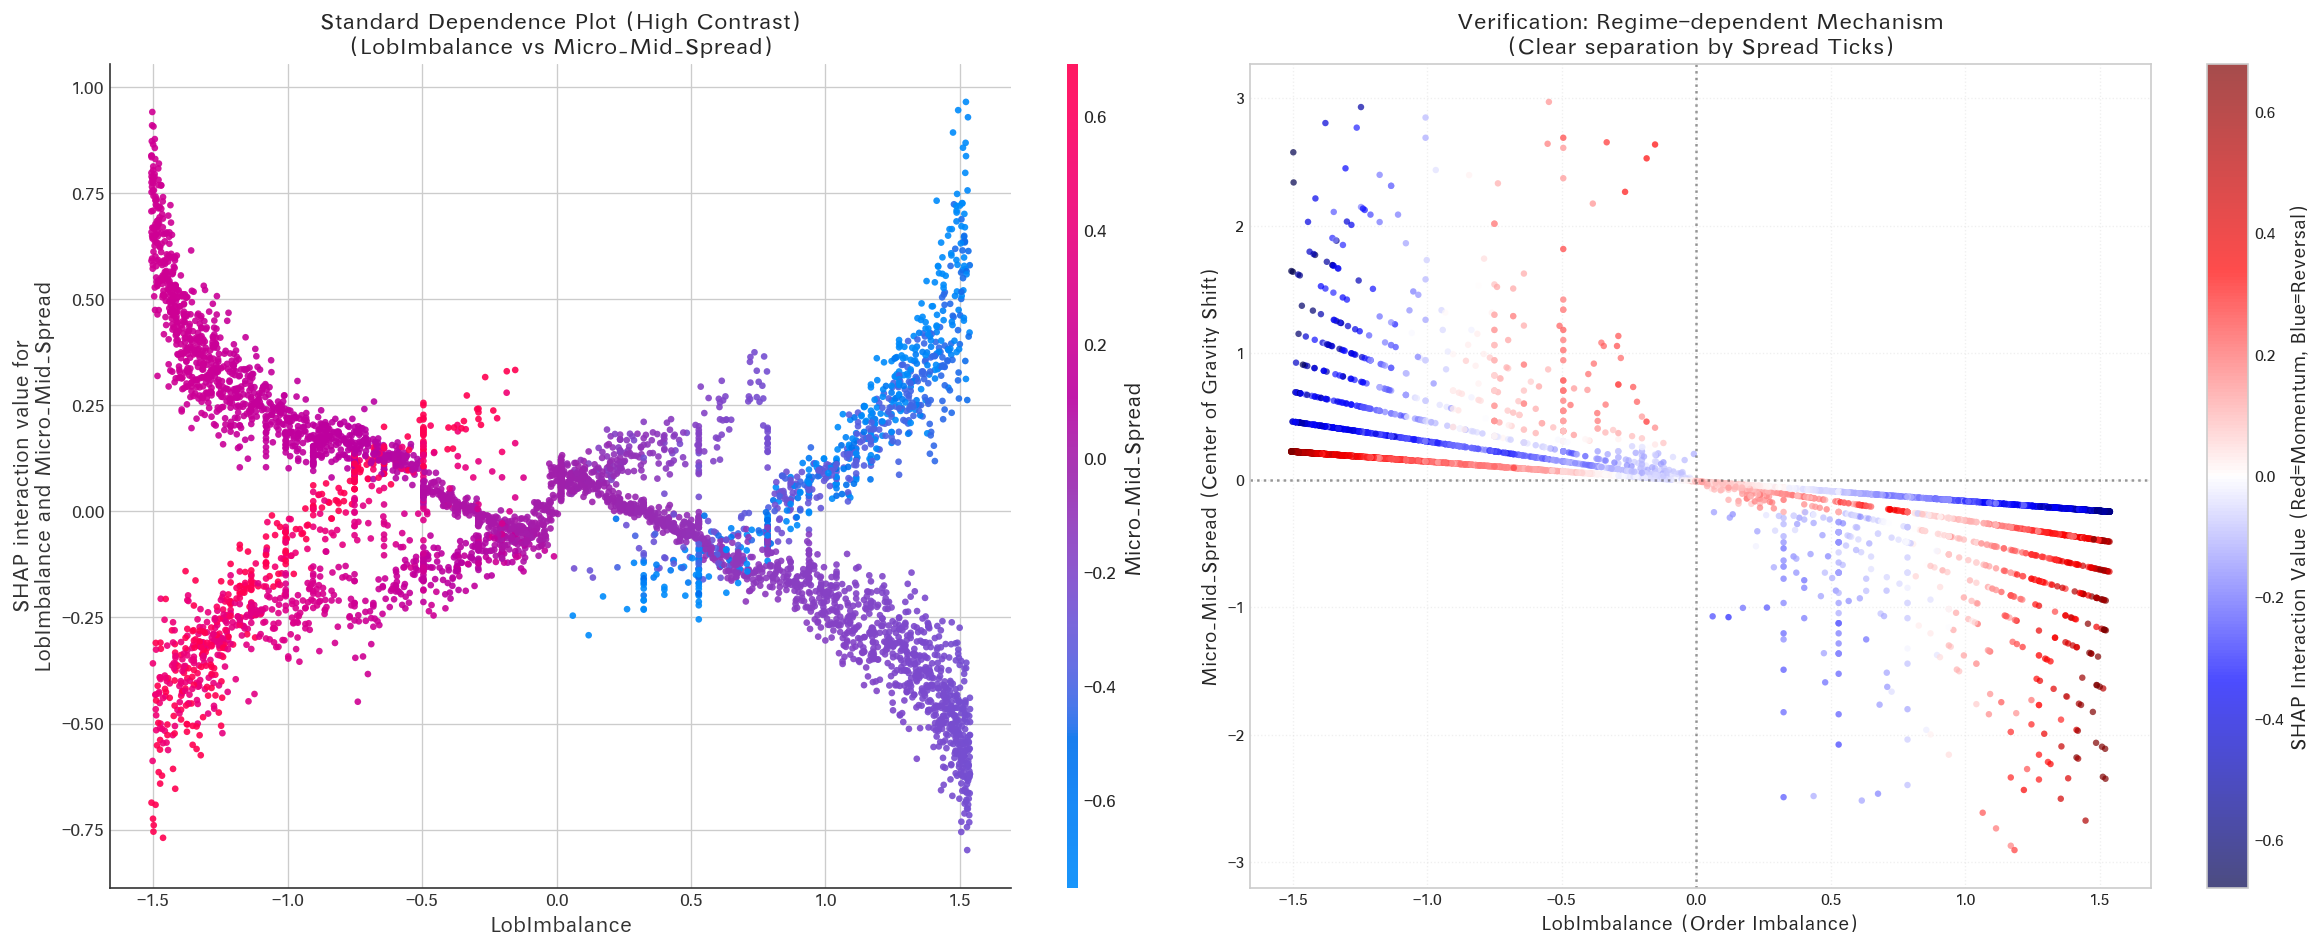

In [11]:
# --- 配置参数 ---
FEAT_X = 'LobImbalance'
FEAT_Y = 'Micro_Mid_Spread'
FILTER_PERCENTILE = 1  # 剔除上下 1% 的极端值以优化显示

def filter_data(df, shap_values, f1, f2, p):
    """剔除极端值，保留中间区域数据"""
    q_low = p / 100
    q_high = 1 - q_low
    mask = (df[f1] >= df[f1].quantile(q_low)) & (df[f1] <= df[f1].quantile(q_high)) & \
           (df[f2] >= df[f2].quantile(q_low)) & (df[f2] <= df[f2].quantile(q_high))
    return df[mask], shap_values[mask]

# 1. 数据准备
X_filtered, shap_filtered = filter_data(X_sample, shap_interaction_values, FEAT_X, FEAT_Y, FILTER_PERCENTILE)
idx_x = FEATURE_COLS.index(FEAT_X)
idx_y = FEATURE_COLS.index(FEAT_Y)

# 2. 绘制图形
fig, axes = plt.subplots(1, 2, figsize=(20, 8), dpi=120)

# --- 图1: SHAP 官方依赖图 (Standard Dependence Plot) ---
# 使用 'cool' 色谱 (青蓝-洋红) 并提高不透明度
plt.sca(axes[0])
shap.dependence_plot(
    (FEAT_X, FEAT_Y), shap_filtered, X_filtered, display_features=X_filtered,
    show=False, ax=axes[0], 
    alpha=0.9,
    dot_size=15,
    interaction_index=FEAT_Y,
    cmap=plt.get_cmap("cool") # 强制使用高对比度的 青蓝-紫(洋红) 色谱
)
axes[0].set_title(f"Standard Dependence Plot (High Contrast)\n({FEAT_X} vs {FEAT_Y})", fontsize=14)

# --- 图2: 自定义交互热力图 (Custom Interaction Map) ---
# 提取交互值并计算颜色范围 (98%分位数)
interaction_effect = shap_filtered[:, idx_x, idx_y] * 2
c_limit = np.percentile(np.abs(interaction_effect), 98)

sc = axes[1].scatter(
    x=X_filtered[FEAT_X], 
    y=X_filtered[FEAT_Y], 
    c=interaction_effect, 
    cmap='seismic',     # 保持红蓝地震波色谱 (红=动量, 蓝=反转) 以区分语义
    s=15, alpha=0.7,    # 略微调整以匹配左图的清晰度
    vmin=-c_limit, vmax=c_limit,
    edgecolor='none'
)

# 装饰图表
cbar = plt.colorbar(sc, ax=axes[1])
cbar.set_label('SHAP Interaction Value (Red=Momentum, Blue=Reversal)', fontsize=12)
axes[1].set_xlabel(f'{FEAT_X} (Order Imbalance)', fontsize=12)
axes[1].set_ylabel(f'{FEAT_Y} (Center of Gravity Shift)', fontsize=12)
axes[1].set_title('Verification: Regime-dependent Mechanism\n(Clear separation by Spread Ticks)', fontsize=14)
axes[1].axhline(0, color='k', linestyle=':', alpha=0.4)
axes[1].axvline(0, color='k', linestyle=':', alpha=0.4)
axes[1].grid(True, linestyle=':', alpha=0.3)

plt.tight_layout()
plt.show()